# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

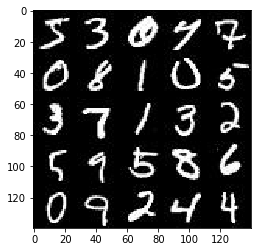

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

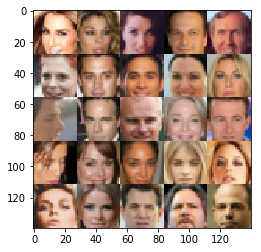

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, name='learn_rate')

    return inputs_real, inputs_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        x = images
        alpha = 0.2 # recommended alpha for leaky relu
        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2 # recommended alpha for leaky relu
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=(2, 2), padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=(2, 2), padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=(1, 1), padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out
    
    return None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # tf.reset_default_graph()
    
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images = batch_images*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})
                
                if steps % 25 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 1.5465... Generator Loss: 1.5864
Epoch 0/2... Discriminator Loss: 1.1900... Generator Loss: 1.0764
Epoch 0/2... Discriminator Loss: 1.5220... Generator Loss: 0.3811
Epoch 0/2... Discriminator Loss: 1.3128... Generator Loss: 0.5094


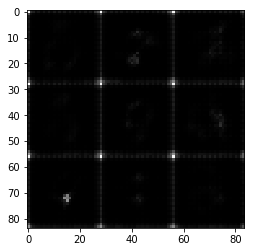

Epoch 0/2... Discriminator Loss: 1.2225... Generator Loss: 0.8730
Epoch 0/2... Discriminator Loss: 1.0652... Generator Loss: 0.8906
Epoch 0/2... Discriminator Loss: 1.2271... Generator Loss: 0.6777
Epoch 0/2... Discriminator Loss: 1.8034... Generator Loss: 2.3641


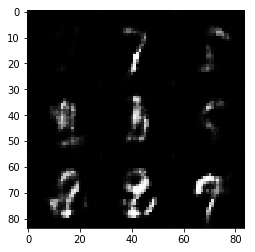

Epoch 0/2... Discriminator Loss: 1.1353... Generator Loss: 0.7175
Epoch 0/2... Discriminator Loss: 1.1513... Generator Loss: 0.8485
Epoch 0/2... Discriminator Loss: 1.7109... Generator Loss: 0.3336
Epoch 0/2... Discriminator Loss: 1.2978... Generator Loss: 0.6727


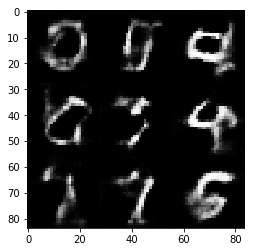

Epoch 0/2... Discriminator Loss: 1.2456... Generator Loss: 0.5811
Epoch 0/2... Discriminator Loss: 1.0458... Generator Loss: 1.4842
Epoch 0/2... Discriminator Loss: 0.8525... Generator Loss: 1.2673
Epoch 0/2... Discriminator Loss: 1.3617... Generator Loss: 0.4717


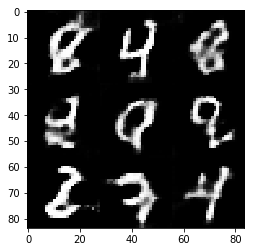

Epoch 0/2... Discriminator Loss: 1.2080... Generator Loss: 0.7899
Epoch 0/2... Discriminator Loss: 1.0008... Generator Loss: 1.2918
Epoch 0/2... Discriminator Loss: 1.3832... Generator Loss: 0.5113
Epoch 0/2... Discriminator Loss: 1.2122... Generator Loss: 1.0827


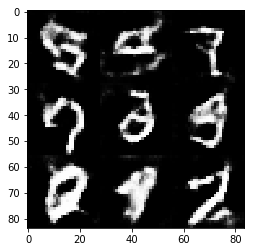

Epoch 0/2... Discriminator Loss: 1.1770... Generator Loss: 0.5525
Epoch 0/2... Discriminator Loss: 1.3872... Generator Loss: 0.3881
Epoch 0/2... Discriminator Loss: 1.2847... Generator Loss: 0.6101
Epoch 0/2... Discriminator Loss: 1.1269... Generator Loss: 0.9764


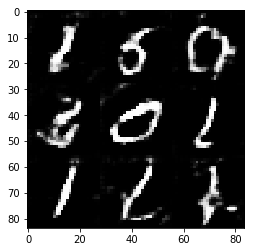

Epoch 0/2... Discriminator Loss: 1.5776... Generator Loss: 0.3400
Epoch 0/2... Discriminator Loss: 1.2797... Generator Loss: 0.6368
Epoch 0/2... Discriminator Loss: 1.2590... Generator Loss: 1.2272
Epoch 0/2... Discriminator Loss: 1.2259... Generator Loss: 0.6908


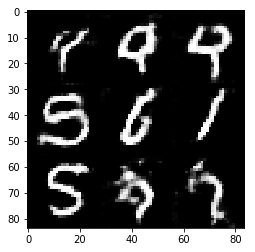

Epoch 0/2... Discriminator Loss: 1.2966... Generator Loss: 1.4226
Epoch 0/2... Discriminator Loss: 1.2226... Generator Loss: 0.9966
Epoch 0/2... Discriminator Loss: 1.5897... Generator Loss: 0.3398
Epoch 0/2... Discriminator Loss: 1.5708... Generator Loss: 0.3178


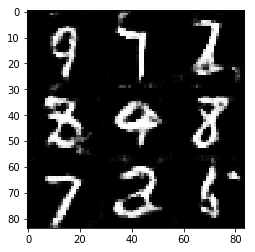

Epoch 0/2... Discriminator Loss: 0.8780... Generator Loss: 1.1780
Epoch 0/2... Discriminator Loss: 1.0227... Generator Loss: 0.6388
Epoch 0/2... Discriminator Loss: 1.1282... Generator Loss: 1.1856
Epoch 0/2... Discriminator Loss: 1.8787... Generator Loss: 2.5071


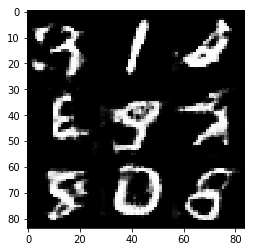

Epoch 0/2... Discriminator Loss: 1.0170... Generator Loss: 1.0894
Epoch 1/2... Discriminator Loss: 0.9025... Generator Loss: 1.3130
Epoch 1/2... Discriminator Loss: 1.0105... Generator Loss: 0.7888
Epoch 1/2... Discriminator Loss: 1.1498... Generator Loss: 0.6049


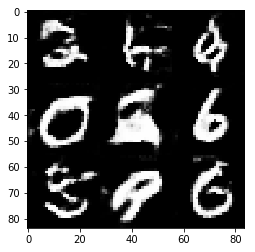

Epoch 1/2... Discriminator Loss: 1.0326... Generator Loss: 0.7537
Epoch 1/2... Discriminator Loss: 0.8563... Generator Loss: 1.4113
Epoch 1/2... Discriminator Loss: 1.1836... Generator Loss: 0.6518
Epoch 1/2... Discriminator Loss: 1.1945... Generator Loss: 0.5075


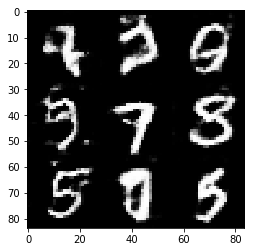

Epoch 1/2... Discriminator Loss: 1.1691... Generator Loss: 0.7038
Epoch 1/2... Discriminator Loss: 1.1611... Generator Loss: 0.9691
Epoch 1/2... Discriminator Loss: 1.3264... Generator Loss: 0.4671
Epoch 1/2... Discriminator Loss: 0.9870... Generator Loss: 0.8404


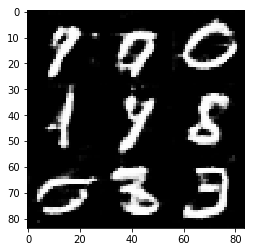

Epoch 1/2... Discriminator Loss: 1.2103... Generator Loss: 1.2902
Epoch 1/2... Discriminator Loss: 0.8498... Generator Loss: 1.1089
Epoch 1/2... Discriminator Loss: 1.2040... Generator Loss: 0.7375
Epoch 1/2... Discriminator Loss: 0.8035... Generator Loss: 1.3229


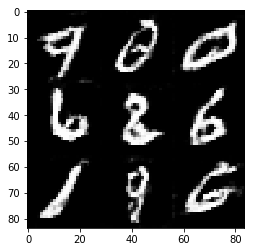

Epoch 1/2... Discriminator Loss: 1.3038... Generator Loss: 0.4616
Epoch 1/2... Discriminator Loss: 1.0277... Generator Loss: 0.7254
Epoch 1/2... Discriminator Loss: 0.6884... Generator Loss: 1.5604
Epoch 1/2... Discriminator Loss: 0.9713... Generator Loss: 0.9742


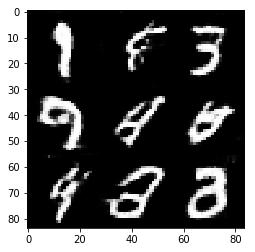

Epoch 1/2... Discriminator Loss: 0.9226... Generator Loss: 0.9086
Epoch 1/2... Discriminator Loss: 2.2886... Generator Loss: 0.1522
Epoch 1/2... Discriminator Loss: 0.6996... Generator Loss: 1.1795
Epoch 1/2... Discriminator Loss: 0.6801... Generator Loss: 1.9192


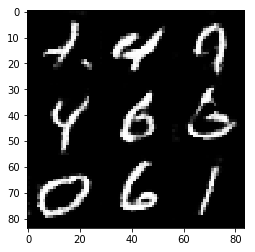

Epoch 1/2... Discriminator Loss: 1.6452... Generator Loss: 0.3192
Epoch 1/2... Discriminator Loss: 0.9753... Generator Loss: 0.8153
Epoch 1/2... Discriminator Loss: 1.2412... Generator Loss: 0.5070
Epoch 1/2... Discriminator Loss: 1.2488... Generator Loss: 2.4174


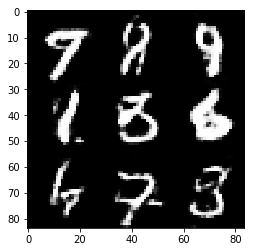

Epoch 1/2... Discriminator Loss: 0.9758... Generator Loss: 0.7771
Epoch 1/2... Discriminator Loss: 0.9920... Generator Loss: 1.7760
Epoch 1/2... Discriminator Loss: 0.8175... Generator Loss: 2.0678
Epoch 1/2... Discriminator Loss: 1.0409... Generator Loss: 0.6336


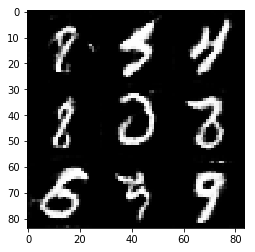

Epoch 1/2... Discriminator Loss: 1.1771... Generator Loss: 0.9793
Epoch 1/2... Discriminator Loss: 0.9717... Generator Loss: 2.0544
Epoch 1/2... Discriminator Loss: 0.6043... Generator Loss: 1.1051
Epoch 1/2... Discriminator Loss: 1.2427... Generator Loss: 0.6335


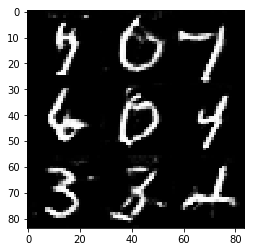

Epoch 1/2... Discriminator Loss: 0.8518... Generator Loss: 0.8338
Epoch 1/2... Discriminator Loss: 1.0237... Generator Loss: 1.5372


In [13]:
tf.reset_default_graph()

batch_size = 64
z_dim = 100
learning_rate = 0.0008
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.0021... Generator Loss: 17.4072
Epoch 0/1... Discriminator Loss: 1.0608... Generator Loss: 1.2327
Epoch 0/1... Discriminator Loss: 4.1858... Generator Loss: 0.0992
Epoch 0/1... Discriminator Loss: 5.9584... Generator Loss: 0.0046


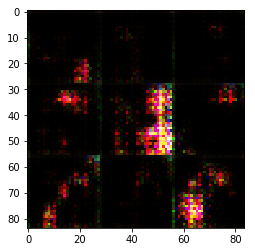

Epoch 0/1... Discriminator Loss: 0.4051... Generator Loss: 1.7249
Epoch 0/1... Discriminator Loss: 5.2409... Generator Loss: 11.4492
Epoch 0/1... Discriminator Loss: 2.3240... Generator Loss: 0.1386
Epoch 0/1... Discriminator Loss: 1.1907... Generator Loss: 0.7458


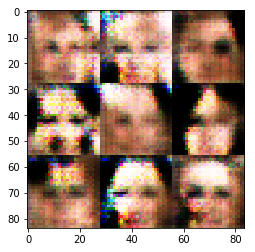

Epoch 0/1... Discriminator Loss: 2.3898... Generator Loss: 0.1607
Epoch 0/1... Discriminator Loss: 1.4898... Generator Loss: 0.6474
Epoch 0/1... Discriminator Loss: 1.3210... Generator Loss: 0.6561
Epoch 0/1... Discriminator Loss: 2.8784... Generator Loss: 3.0387


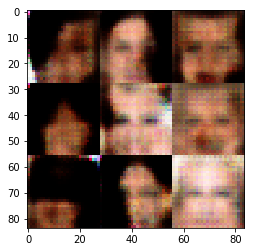

Epoch 0/1... Discriminator Loss: 1.3661... Generator Loss: 0.4204
Epoch 0/1... Discriminator Loss: 1.7787... Generator Loss: 1.6787
Epoch 0/1... Discriminator Loss: 1.6596... Generator Loss: 0.3268
Epoch 0/1... Discriminator Loss: 1.4060... Generator Loss: 0.4265


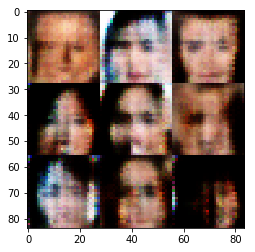

Epoch 0/1... Discriminator Loss: 1.1837... Generator Loss: 0.5870
Epoch 0/1... Discriminator Loss: 1.6320... Generator Loss: 0.5664
Epoch 0/1... Discriminator Loss: 1.5975... Generator Loss: 0.4090
Epoch 0/1... Discriminator Loss: 1.5753... Generator Loss: 0.3525


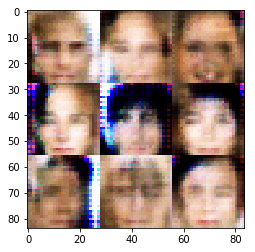

Epoch 0/1... Discriminator Loss: 1.9351... Generator Loss: 1.9413
Epoch 0/1... Discriminator Loss: 1.1010... Generator Loss: 0.6585
Epoch 0/1... Discriminator Loss: 2.4146... Generator Loss: 0.1460
Epoch 0/1... Discriminator Loss: 0.7647... Generator Loss: 1.5708


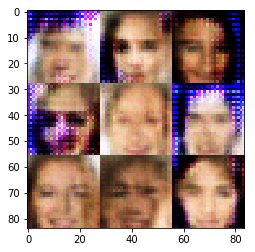

Epoch 0/1... Discriminator Loss: 1.8727... Generator Loss: 0.3467
Epoch 0/1... Discriminator Loss: 1.2323... Generator Loss: 0.7065
Epoch 0/1... Discriminator Loss: 1.2919... Generator Loss: 0.6427
Epoch 0/1... Discriminator Loss: 1.9017... Generator Loss: 0.2635


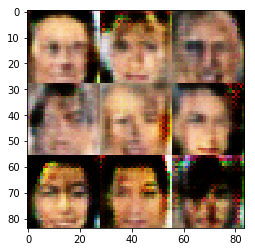

Epoch 0/1... Discriminator Loss: 1.3221... Generator Loss: 0.6482
Epoch 0/1... Discriminator Loss: 1.6469... Generator Loss: 0.3929
Epoch 0/1... Discriminator Loss: 1.0698... Generator Loss: 0.9547
Epoch 0/1... Discriminator Loss: 1.3932... Generator Loss: 0.5966


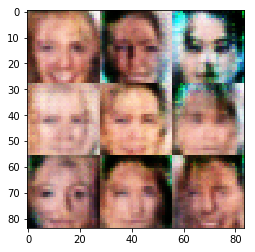

Epoch 0/1... Discriminator Loss: 1.6524... Generator Loss: 0.2760
Epoch 0/1... Discriminator Loss: 1.6423... Generator Loss: 0.2929
Epoch 0/1... Discriminator Loss: 1.3836... Generator Loss: 0.6826
Epoch 0/1... Discriminator Loss: 2.3167... Generator Loss: 2.3116


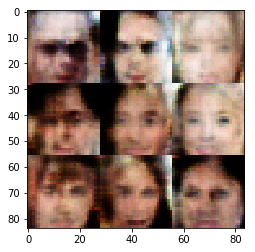

Epoch 0/1... Discriminator Loss: 1.6122... Generator Loss: 0.5577
Epoch 0/1... Discriminator Loss: 1.5558... Generator Loss: 0.2744
Epoch 0/1... Discriminator Loss: 1.4008... Generator Loss: 0.6468
Epoch 0/1... Discriminator Loss: 1.2245... Generator Loss: 1.0055


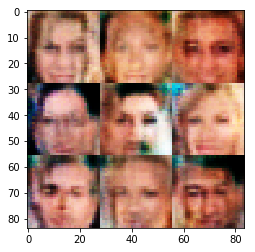

Epoch 0/1... Discriminator Loss: 1.6696... Generator Loss: 0.3851
Epoch 0/1... Discriminator Loss: 1.3033... Generator Loss: 0.5744
Epoch 0/1... Discriminator Loss: 1.8375... Generator Loss: 0.5227
Epoch 0/1... Discriminator Loss: 2.3621... Generator Loss: 1.2326


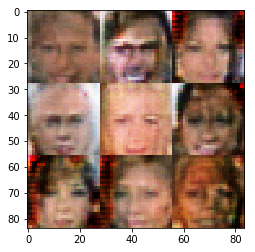

Epoch 0/1... Discriminator Loss: 1.8000... Generator Loss: 0.3043
Epoch 0/1... Discriminator Loss: 1.3178... Generator Loss: 0.7573
Epoch 0/1... Discriminator Loss: 1.5903... Generator Loss: 0.5371
Epoch 0/1... Discriminator Loss: 1.9938... Generator Loss: 1.0001


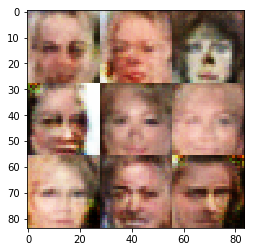

Epoch 0/1... Discriminator Loss: 2.8542... Generator Loss: 2.4795
Epoch 0/1... Discriminator Loss: 1.2981... Generator Loss: 0.5442
Epoch 0/1... Discriminator Loss: 1.6731... Generator Loss: 1.3068
Epoch 0/1... Discriminator Loss: 1.6815... Generator Loss: 0.3354


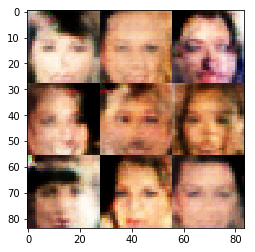

Epoch 0/1... Discriminator Loss: 1.3268... Generator Loss: 0.8311
Epoch 0/1... Discriminator Loss: 1.4143... Generator Loss: 0.4939
Epoch 0/1... Discriminator Loss: 0.6728... Generator Loss: 1.0222
Epoch 0/1... Discriminator Loss: 1.7752... Generator Loss: 0.4546


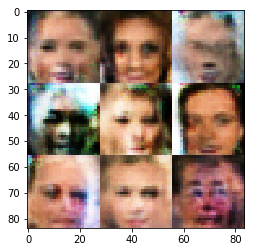

Epoch 0/1... Discriminator Loss: 1.8084... Generator Loss: 0.2619
Epoch 0/1... Discriminator Loss: 2.2419... Generator Loss: 0.1544
Epoch 0/1... Discriminator Loss: 1.8628... Generator Loss: 0.2289
Epoch 0/1... Discriminator Loss: 1.7678... Generator Loss: 0.3137


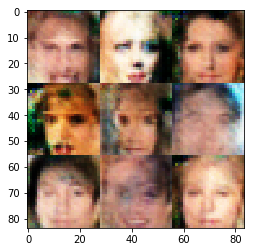

Epoch 0/1... Discriminator Loss: 1.3933... Generator Loss: 0.5030
Epoch 0/1... Discriminator Loss: 1.6123... Generator Loss: 0.6234
Epoch 0/1... Discriminator Loss: 1.7594... Generator Loss: 0.4129
Epoch 0/1... Discriminator Loss: 1.7086... Generator Loss: 0.3870


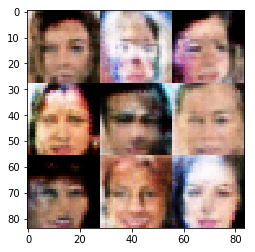

Epoch 0/1... Discriminator Loss: 1.6823... Generator Loss: 0.3217
Epoch 0/1... Discriminator Loss: 1.3676... Generator Loss: 0.8604
Epoch 0/1... Discriminator Loss: 1.4308... Generator Loss: 0.4431
Epoch 0/1... Discriminator Loss: 1.4742... Generator Loss: 0.5590


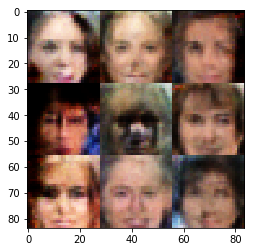

Epoch 0/1... Discriminator Loss: 1.5663... Generator Loss: 0.6496
Epoch 0/1... Discriminator Loss: 1.5207... Generator Loss: 0.5827
Epoch 0/1... Discriminator Loss: 1.5129... Generator Loss: 0.4183
Epoch 0/1... Discriminator Loss: 1.6239... Generator Loss: 0.6549


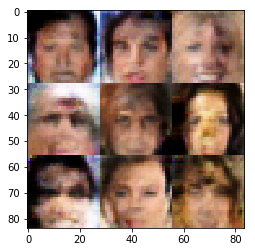

Epoch 0/1... Discriminator Loss: 2.1403... Generator Loss: 0.1592
Epoch 0/1... Discriminator Loss: 1.5778... Generator Loss: 0.4162
Epoch 0/1... Discriminator Loss: 1.7321... Generator Loss: 0.3181
Epoch 0/1... Discriminator Loss: 1.4204... Generator Loss: 0.8135


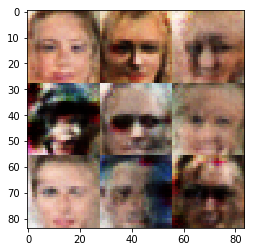

Epoch 0/1... Discriminator Loss: 1.5662... Generator Loss: 1.0857
Epoch 0/1... Discriminator Loss: 1.5542... Generator Loss: 0.3687
Epoch 0/1... Discriminator Loss: 1.5855... Generator Loss: 0.3959
Epoch 0/1... Discriminator Loss: 1.5261... Generator Loss: 1.0189


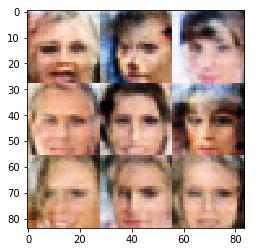

Epoch 0/1... Discriminator Loss: 1.5633... Generator Loss: 0.3759
Epoch 0/1... Discriminator Loss: 1.6921... Generator Loss: 0.4254
Epoch 0/1... Discriminator Loss: 1.5780... Generator Loss: 0.4767
Epoch 0/1... Discriminator Loss: 1.8058... Generator Loss: 1.0830


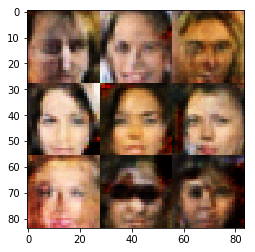

Epoch 0/1... Discriminator Loss: 1.3462... Generator Loss: 0.8039
Epoch 0/1... Discriminator Loss: 1.7144... Generator Loss: 0.5562
Epoch 0/1... Discriminator Loss: 1.6687... Generator Loss: 0.5090
Epoch 0/1... Discriminator Loss: 1.6816... Generator Loss: 0.5340


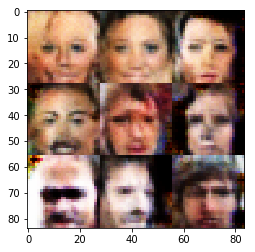

Epoch 0/1... Discriminator Loss: 1.5011... Generator Loss: 0.7870
Epoch 0/1... Discriminator Loss: 1.6299... Generator Loss: 1.0015
Epoch 0/1... Discriminator Loss: 1.6500... Generator Loss: 0.6690
Epoch 0/1... Discriminator Loss: 1.8857... Generator Loss: 0.2512


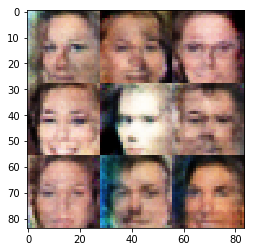

Epoch 0/1... Discriminator Loss: 1.7173... Generator Loss: 0.4738
Epoch 0/1... Discriminator Loss: 1.9672... Generator Loss: 0.2120
Epoch 0/1... Discriminator Loss: 1.6560... Generator Loss: 0.9284
Epoch 0/1... Discriminator Loss: 1.7428... Generator Loss: 0.3019


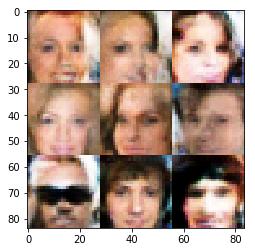

Epoch 0/1... Discriminator Loss: 2.0201... Generator Loss: 0.2059
Epoch 0/1... Discriminator Loss: 1.3915... Generator Loss: 0.3796
Epoch 0/1... Discriminator Loss: 1.6480... Generator Loss: 0.2899
Epoch 0/1... Discriminator Loss: 1.8895... Generator Loss: 0.3432


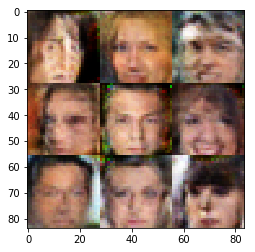

Epoch 0/1... Discriminator Loss: 1.7920... Generator Loss: 0.3065
Epoch 0/1... Discriminator Loss: 1.8554... Generator Loss: 0.3303
Epoch 0/1... Discriminator Loss: 2.4745... Generator Loss: 1.5586
Epoch 0/1... Discriminator Loss: 2.0410... Generator Loss: 0.2128


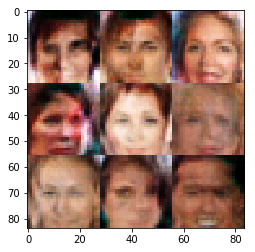

Epoch 0/1... Discriminator Loss: 1.8753... Generator Loss: 0.2917
Epoch 0/1... Discriminator Loss: 1.6218... Generator Loss: 0.4787
Epoch 0/1... Discriminator Loss: 1.8086... Generator Loss: 0.3726
Epoch 0/1... Discriminator Loss: 1.8260... Generator Loss: 1.2309


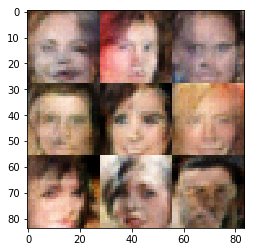

Epoch 0/1... Discriminator Loss: 1.8606... Generator Loss: 0.3961
Epoch 0/1... Discriminator Loss: 1.6506... Generator Loss: 0.3785
Epoch 0/1... Discriminator Loss: 1.6105... Generator Loss: 0.3400
Epoch 0/1... Discriminator Loss: 1.9187... Generator Loss: 0.3663


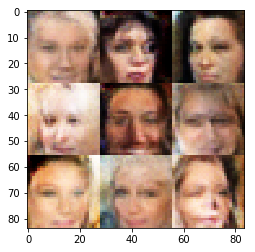

Epoch 0/1... Discriminator Loss: 1.8400... Generator Loss: 0.3362
Epoch 0/1... Discriminator Loss: 1.7524... Generator Loss: 0.4233
Epoch 0/1... Discriminator Loss: 1.7507... Generator Loss: 0.4071
Epoch 0/1... Discriminator Loss: 1.6863... Generator Loss: 0.5849


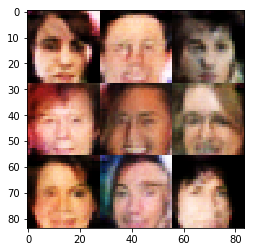

Epoch 0/1... Discriminator Loss: 1.7565... Generator Loss: 0.3454
Epoch 0/1... Discriminator Loss: 1.9290... Generator Loss: 1.0235
Epoch 0/1... Discriminator Loss: 1.9314... Generator Loss: 0.2563
Epoch 0/1... Discriminator Loss: 1.7663... Generator Loss: 0.2704


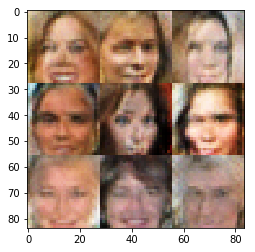

Epoch 0/1... Discriminator Loss: 1.7615... Generator Loss: 0.3235
Epoch 0/1... Discriminator Loss: 1.6937... Generator Loss: 0.3210
Epoch 0/1... Discriminator Loss: 1.8863... Generator Loss: 0.6034
Epoch 0/1... Discriminator Loss: 1.6026... Generator Loss: 0.3778


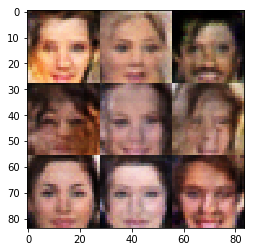

Epoch 0/1... Discriminator Loss: 1.6898... Generator Loss: 0.3963
Epoch 0/1... Discriminator Loss: 1.7604... Generator Loss: 0.2747


In [14]:
batch_size = 64
z_dim = 1000
learning_rate = 0.0008
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.